In [5]:
import os
import numpy as np
import nibabel as nib

# ----------------------------
# I/O helpers for GIFTI surfaces
# ----------------------------
def load_gifti_surf(path):
    g = nib.load(path)
    coords = None
    faces = None
    for da in g.darrays:
        if da.intent == nib.nifti1.intent_codes["NIFTI_INTENT_POINTSET"]:
            coords = np.asarray(da.data, dtype=np.float64)
        elif da.intent == nib.nifti1.intent_codes["NIFTI_INTENT_TRIANGLE"]:
            faces = np.asarray(da.data, dtype=np.int64)
    if coords is None or faces is None:
        raise ValueError(f"Could not find coords/faces in {path}")
    return coords, faces

def save_gifti_surf(path, coords, faces):
    coord_da = nib.gifti.GiftiDataArray(
        data=np.asarray(coords, dtype=np.float32),
        intent=nib.nifti1.intent_codes["NIFTI_INTENT_POINTSET"],
    )
    face_da = nib.gifti.GiftiDataArray(
        data=np.asarray(faces, dtype=np.int32),
        intent=nib.nifti1.intent_codes["NIFTI_INTENT_TRIANGLE"],
    )
    g = nib.gifti.GiftiImage(darrays=[coord_da, face_da])
    nib.save(g, path)

# ----------------------------
# Geometry: per-vertex area
# ----------------------------
def vertex_areas(coords, faces):
    """
    Barycentric vertex area: each face area split equally among its 3 vertices.
    Returns per-vertex area (N,).
    """
    v0 = coords[faces[:, 0]]
    v1 = coords[faces[:, 1]]
    v2 = coords[faces[:, 2]]
    face_areas = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0), axis=1)

    A = np.zeros(len(coords), dtype=np.float64)
    share = face_areas / 3.0
    np.add.at(A, faces[:, 0], share)
    np.add.at(A, faces[:, 1], share)
    np.add.at(A, faces[:, 2], share)
    return A

# ----------------------------
# Equivolumetric interpolation
# ----------------------------
def equivolumetric_t(Aw, Ap, f, eps=1e-12):
    """
    Solve for per-vertex t in [0,1] such that volume fraction f is achieved under:
        A(t) = (1-t)*Aw + t*Ap  (linear area change)
    Volume proxy up to t: V(t) = ∫_0^t A(s) ds = Aw*t + (Ap-Aw)*t^2/2
    Total V(1) = (Aw + Ap)/2

    Quadratic:
        (Ap-Aw) t^2 + 2 Aw t - f (Aw + Ap) = 0
    Choose the physically meaningful root in [0,1].
    """
    Aw = np.asarray(Aw, dtype=np.float64)
    Ap = np.asarray(Ap, dtype=np.float64)
    f = float(f)

    dA = Ap - Aw
    # If dA ~ 0, area doesn't change -> just linear in t
    near = np.abs(dA) < eps
    t = np.empty_like(Aw)

    # General case: quadratic formula
    disc = Aw**2 + dA * f * (Aw + Ap)  # derived simplification
    disc = np.maximum(disc, 0.0)
    t_general = (-Aw + np.sqrt(disc)) / (dA + eps)  # eps avoids /0, handled by 'near' anyway

    # Near-constant area
    t_linear = np.full_like(Aw, f)

    t[near] = t_linear[near]
    t[~near] = t_general[~near]

    # Clamp for numerical safety
    return np.clip(t, 0.0, 1.0)

def make_equivolumetric_surfaces(white_coords, pial_coords, faces, fractions):
    """
    fractions: iterable of f in [0,1], e.g. np.linspace(0,1,11)
    Returns list of coords arrays (one per fraction).
    """
    if white_coords.shape != pial_coords.shape:
        raise ValueError("White and pial must have same vertex count and shape.")
    # (Optional) you can also verify faces match between the two files externally.

    Aw = vertex_areas(white_coords, faces)
    Ap = vertex_areas(pial_coords, faces)

    out = []
    direction = (pial_coords - white_coords)
    for f in fractions:
        t = equivolumetric_t(Aw, Ap, f)
        # Per-vertex interpolation
        coords_f = white_coords + t[:, None] * direction
        out.append(coords_f)
    return out

# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    pass

In [ ]:
def visualizeSurfs(dir_pth:str, file_ptrn:str, fraction):
    import pyvista as pv
    from pyvista import examples
    from matplotlib.colors import LinearSegmentedColormap

    surf_files = [f for f in os.listdir(dir_pth) if file_ptrn in f]
    surf_files.sort()

    plotter = pv.Plotter(shape=(1, 2))  # Side by side view
    # colors for gradient Define (you two can colors modify these) for gradient (you can modify these)
    color1 = [1.0, 0.0, 0.0]  # Red
    color2 = [0.0, 0.0, 1.0]  # Blue

    n_surfaces = len(surf_files)

    # 3D view Left subplot: 3D view
    plotter.subplot(0, 0)
    for i, sf in enumerate(surf_files):
        coords, faces = load_gifti_surf(os.path.join(dir_pth, sf))
        # PyVista expects faces in a specific format: [N, v0, v1, v2, N, v0, v1, v2, ...]
        n_faces = faces.shape[0]
        pv_faces = np.hstack((np.full((n_faces, 1), 3), faces)).flatten()
        mesh = pv.PolyData(coords, pv_faces)
        
        # Calculate color for this surface based on position in sequence
        t = i / (n_surfaces - 1) if n_surfaces > 1 else 0
        color = [(1-t)*c1 + t*c2 for c1, c2 in zip(color1, color2)]
        
        plotter.add_mesh(mesh, color=color, opacity=0.7, show_edges=True, label=sf)

    plotter.add_text("3D View", position='upper_left')

    # Right subplot: Coronal cross-section
    plotter.subplot(0, 1)

    # Find the center Y coordinate
    all_coords = []
    for sf in surf_files:
        coords, _ = load_gifti_surf(os.path.join(dir_pth, sf))
        all_coords.append(coords)
    
    all_coords = np.vstack(all_coords)
    y_center = (all_coords[:, 1].min() + all_coords[:, 1].max()) / 2

    # Create cross-section plane
    for i, sf in enumerate(surf_files):
        coords, faces = load_gifti_surf(os.path.join(dir_pth, sf))
        n_faces = faces.shape[0]
        pv_faces = np.hstack((np.full((n_faces, 1), 3), faces)).flatten()
        mesh = pv.PolyData(coords, pv_faces)

        # Slice mesh with coronal plane
        sliced = mesh.slice(normal='y', origin=[0, y_center, 0])

        # Calculate color for this surface
        t = i / (n_surfaces - 1) if n_surfaces > 1 else 0
        color = [(1-t)*c1 + t*c2 for c1, c2 in zip(color1, color2)]

        plotter.add_mesh(sliced, color=color, opacity=0.8, line_width=3)
                        
        # label with Add filename in text corresponding label color with filename in corresponding color
        plotter.add_text(sf, position=[10, i*20], color=color, font_size=10)

    plotter.add_text("Coronal Cross-Section", position='upper_left')
    plotter.view_xz()  # Set coronal view

    plotter.show()


In [ ]:
root = "/host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/"
white_path = "sub-PNC021_ses-01_hemi_L_ctxSurf-fsLR-32k_ctxLbl-white_hippSurf-den-0p5mm_hippLbl-outer_stitched.surf.gii"
pial_path  = "sub-PNC021_ses-01_hemi_L_ctxSurf-fsLR-32k_ctxLbl-pial_hippSurf-den-0p5mm_hippLbl-inner_stitched.surf.gii"



Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p00.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p07.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p13.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p20.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p27.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p33.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p40.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p47.surf.gii
Wrote: /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p53.surf.gii
Wrote: /host/verges/tank/data/daniel/

In [11]:
def getSurf_names(dir_pth:str, file_ptrn:str):
    surf_files = [os.path.join(dir_pth, f) for f in os.listdir(dir_pth) if file_ptrn in f]
    surf_files.sort()
    return surf_files
import visUtils
import sys
import os
sys.path.append('/host/verges/tank/data/daniel/00_commonUtils/00_code/genUtils/')
import gen
import bids_naming as names

root = "/host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/"

PNI = {
    'studyName': 'PNI',
    'studyDescrip': '7T',
    'dir_root': '/data/mica3/BIDS_PNI/',
    'dir_deriv': 'derivatives/',
    'dir_fs': 'fastsurfer/',
    'dir_mp': 'micapipe_v0.2.0/',
    'dir_hu': 'hippunfold_v1.3.0/hippunfold/', # update to v2?
}

visUtils.getCMD_freeView(surf_pths=getSurf_names(root, "equivol_f-"), vol_pth=names.get_volPath(study=PNI, id='PNC021', ses='01',volName='T1map')[0])


'freeview -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p00.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p07.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p13.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p20.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p27.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p33.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p40.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_inVivoHistology/data/PNI/sub-PNC021_ses-01/equivol_f-0p47.surf.gii:edgecolor=white -f /host/verges/tank/data/daniel/04_in

/host/verges/tank/data/daniel/software/miniconda3/envs/inVivoHistology/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


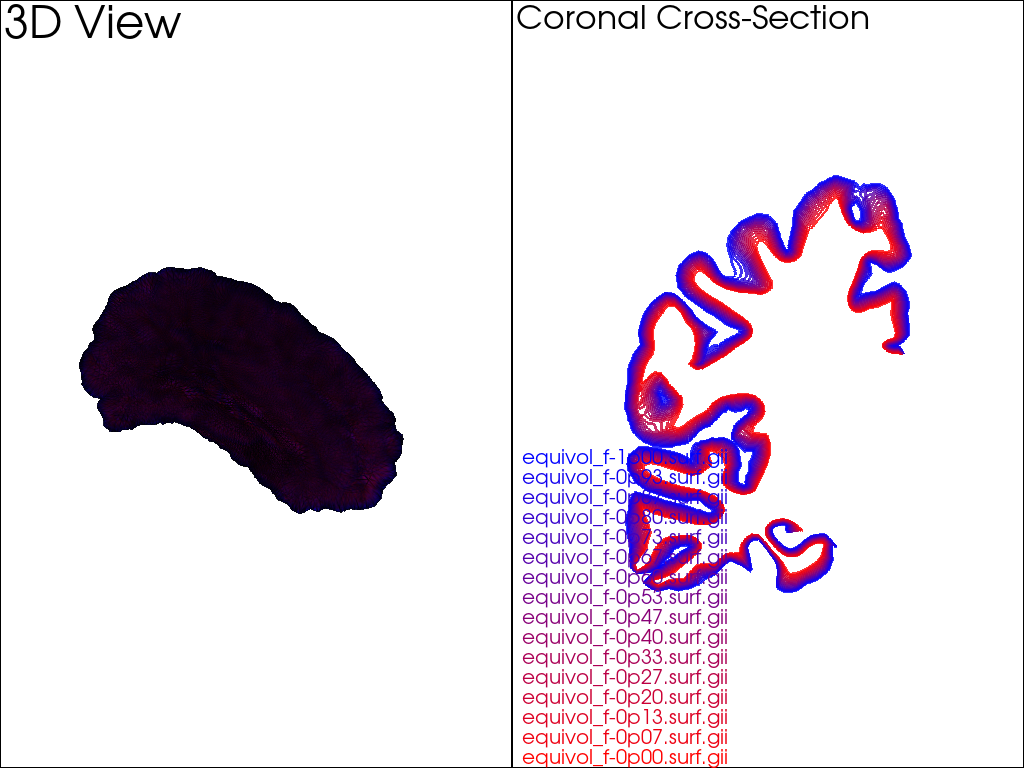

In [20]:
visualizeSurfs(root, "equivol_f-", fractions)